In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/foram/OneDrive/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cur= conn.cursor()
print("✅ Connected successfully")



✅ Connected successfully


# List all unique cities where customers are located.

In [12]:
query = """select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns=["customer_city"])
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [14]:
query = """ select count(order_id) 
            from orders
            where year(order_purchase_timestamp)=2017
        """
cur.execute(query)
data=cur.fetchall()
"Total Order placed in 2017 are ",data[0][0]

('Total Order placed in 2017 are ', 225505)

#  Find the total sales per category.

In [23]:
query = """ select upper(a.product_category) as Category, round(sum(b.payment_value),2) as Total_sales
            from products as a
            inner join order_items as c
            on a.product_id=c.product_id
            inner join payments as b
            on c.order_id=b.order_id
            group by Category
        """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Total_sales"])
df

,Category,Total_sales
0,TELEPHONY,19998852.83
1,BED TABLE BATH,69852294.04
2,AUTOMOTIVE,34621470.65
3,COMPUTER ACCESSORIES,64666724.05
4,FURNITURE DECORATION,58032607.87
...,...,...
69,CDS MUSIC DVDS,49476.00
70,LA CUISINE,116541.20
71,FASHION CHILDREN'S CLOTHING,31426.80
72,PC GAMER,86977.20


# Calculate the percentage of orders that were paid in more than 2 installments.

In [8]:
query = "select (sum(case when payment_installments>2 then 1 else 0 end))/count(*)*100 from payments"
cur.execute(query)
data=cur.fetchall()
"The percentage of orders that were paid in more than 2 installments is ",data[0][0]

('The percentage of orders that were paid in more than 2 installments is ',
 Decimal('37.4700'))

# Count the number of customers from each state. 

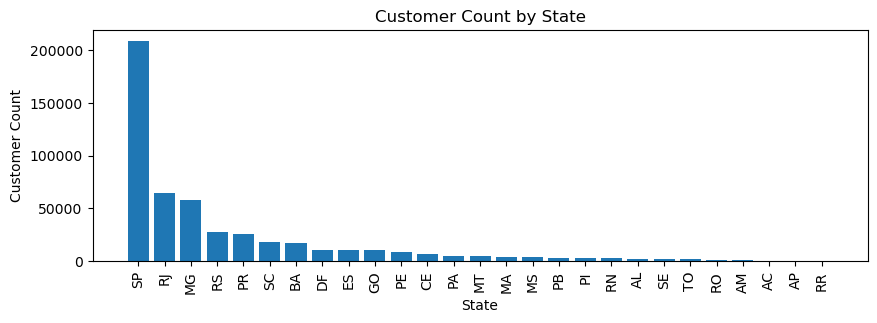

In [3]:
query = "select count(customer_id),customer_state from customers group by customer_state"
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data,columns=['Customer_count','State'])
df = df.sort_values(by='Customer_count',ascending=False)

plt.figure(figsize=(10,3))
plt.bar(df["State"],df["Customer_count"])
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("Customer Count by State")
plt.show()

# Calculate the number of orders per month in 2018.

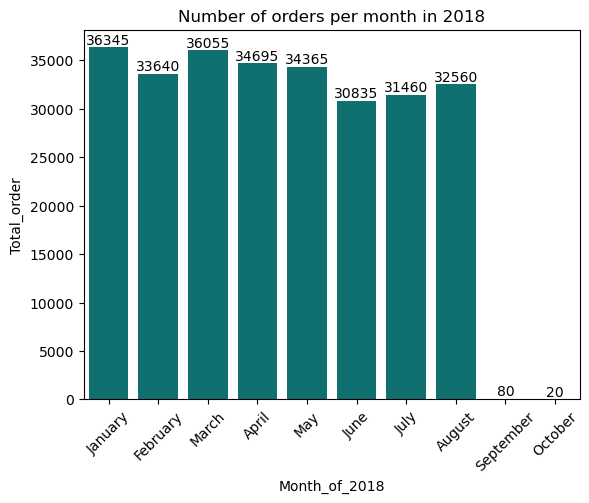

In [12]:
query="""select monthname(order_purchase_timestamp) as month,count(order_id) as total_order
from orders
where year(order_purchase_timestamp)=2018
group by monthname(order_purchase_timestamp)
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Month_of_2018","Total_order"])

o = ["January","February","March","April","May","June",
         "July","August","September","October"]

ax=sns.barplot(x="Month_of_2018", y="Total_order", data=df, order=o, color='teal')
plt.title("Number of orders per month in 2018")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city.

In [11]:
query="""
with count_per_order as (
select o.order_id,o.customer_id,count(oi.order_item_id) as x
from orders as o
inner join order_items as oi
on o.order_id=oi.order_id
group by o.order_id,o.customer_id
)

select upper(c.customer_city),avg(cpo.x) as avg_ord
from customers as c
inner join count_per_order as cpo
on c.customer_id=cpo.customer_id
group by c.customer_city
order by avg_ord desc
"""

cur.execute(query)
data=cur.fetchall()
print('Top 5 Cities with Highest Average Orders')
df=pd.DataFrame(data,columns=['City','Avg_orders'])
df.head()

Top 5 Cities with Highest Average Orders


,City,Avg_orders
0,PADRE CARVALHO,70.0000
1,CELSO RAMOS,65.0000
2,DATAS,60.0000
3,CANDIDO GODOI,60.0000
4,MATIAS OLIMPIO,50.0000


# Calculate the percentage of total revenue contributed by each product category.

In [24]:
query="""
select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products 
inner join order_items 
on products.product_id = order_items.product_id
inner join payments 
on payments.order_id = order_items.order_id
group by category 
order by sales_percentage desc
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,109.08
1,HEALTH BEAUTY,104.90
2,COMPUTER ACCESSORIES,100.99
3,FURNITURE DECORATION,90.63
4,WATCHES PRESENT,90.39


 # Identify the correlation between product price and the number of times a product has been purchased.
 

In [18]:
query="""
select p.product_category,count(o.product_id),round(avg(o.price),2)
from order_items as o
inner join products as p
on o.product_id=p.product_id
group by p.product_category
"""
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data,columns = ["category", "order_count","price"])

arr1=df["order_count"]
arr2=df["price"]

a=np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased",a[0][1])

The correlation between product price and the number of times a product has been purchased -0.10702567576310347


 # Calculate the total revenue generated by each seller, and rank them by revenue.

In [2]:
query="""
select *,dense_rank() over(order by revenue desc) as ranks
from 
(select o.seller_id,round(sum(p.payment_value),2) as revenue
from order_items as o
inner join payments as p
on o.order_id=p.order_id
group by o.seller_id) as a
"""
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data,columns = ["seller_id", "revenue","rank"])
df.head()

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,4121931.18,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,2516909.12,2
2,4a3ca9315b744ce9f8e9374361493884,2448771.16,3
3,1f50f920176fa81dab994f9023523100,2343967.44,4
4,53243585a1d6dc2643021fd1853d8905,2341305.52,5


 # Calculate the moving average of order values for each customer over their order history.

In [5]:
query = """
select customer_id,order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as moving_avg
from
(select o.customer_id,o.order_purchase_timestamp,sum(p.payment_value) as payment
from payments as p
inner join orders as o
on p.order_id=o.order_id
group by o.customer_id,o.order_purchase_timestamp) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_id", "order_purchase_timestamp","payment"])
df.head()


,customer_id,order_purchase_timestamp,payment
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,2294.799957
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,1348.200073
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,3908.399963
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,3587.000122
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,2140.200043


# Calculate the cumulative sales per month for each year.

In [7]:
query = """
select years,months,payment,sum(payment) over(order by years,months) as cumulative_sales from 
(select year(o.order_purchase_timestamp) as years, month(o.order_purchase_timestamp) as months,round(sum(p.payment_value),2)as payment
from orders as o
inner join payments as p
on o.order_id=p.order_id
group by years,months
order by years,months) as a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years", "months","payment","cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,9,5044.80,5.044800e+03
1,2016,10,1181809.60,1.186854e+06
2,2016,12,392.40,1.187247e+06
3,2017,1,2769760.80,3.957008e+06
4,2017,2,5838160.19,9.795168e+06
5,2017,3,8997271.99,1.879244e+07
6,2017,4,8355760.59,2.714820e+07
7,2017,5,11858376.40,3.900658e+07
8,2017,6,10225527.61,4.923210e+07
9,2017,7,11847658.39,6.107976e+07


# Calculate the year-over-year growth rate of total sales

In [19]:
query = """
with a as
(select year(o.order_purchase_timestamp) as years,round(sum(p.payment_value),2)as payment
from orders as o
inner join payments as p
on o.order_id=p.order_id
group by years)

select years,round(((payment-lag(payment,1) over (order by years))/lag(payment,1) over (order by years))*100,2) as yoy_percentage from a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["year","yoy_percentage"])
df


,year,yoy_percentage
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# For each customer, count how many times they returned and made another order within 6 months of their first purchase.


In [11]:
query = """
with a as(select c.customer_id,min(o.order_purchase_timestamp) as first_order
from customers as c
inner join orders as o
on c.customer_id=o.customer_id
group by c.customer_id)

select a.customer_id,count(distinct o.order_purchase_timestamp) as count_of_order_within_6_month
from a
inner join orders as o
on a.customer_id=o.customer_id
and o.order_purchase_timestamp>first_order
and o.order_purchase_timestamp<date_add(first_order, interval 6 month)
group by a.customer_id
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_id","count_of_order_within_6_month"])
df

#Query counts repeat orders within 6 months of first purchase per customer. Dataset has mostly unique orders, so counts are mostly zero

,customer_id,count_of_order_within_6_month


# Identify the top 3 customers who spent the most money in each year.

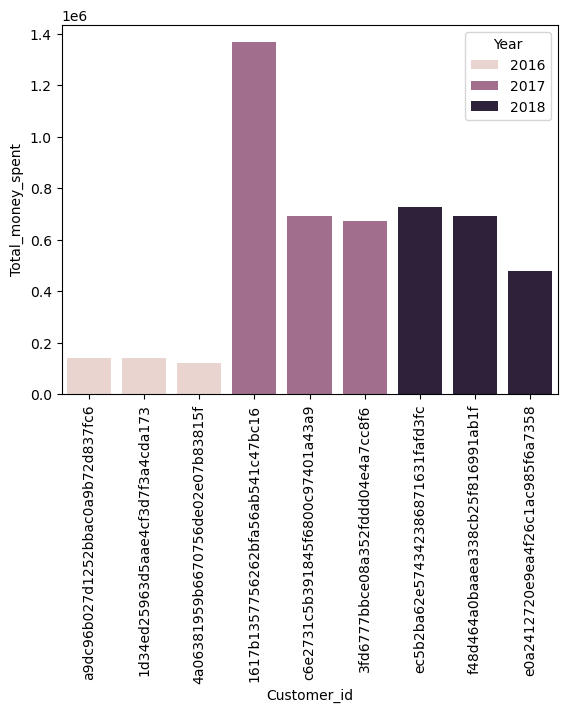

In [18]:
query = """
select o_year,customer_id,total_money_spent,d_rank from 
(select year(o.order_purchase_timestamp) as o_year,c.customer_id,sum(p.payment_value) as total_money_spent,
dense_rank() over(partition by year(o.order_purchase_timestamp) order by sum(p.payment_value) desc) as d_rank
from customers as c
inner join orders as o
on c.customer_id=o.customer_id
inner join payments as p
on o.order_id=p.order_id
group by c.customer_id,o_year
order by o_year asc) as a
where d_rank <= 3;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Year","Customer_id","Total_money_spent","Rank"])
sns.barplot(x="Customer_id",y="Total_money_spent",data=df,hue="Year")
plt.xticks(rotation=90)
plt.show()